# 1D regression 

In [1]:
import sys
sys.path.append('/homes/mlghomes/mh740/GPflow')
sys.path.append('/homes/mlghomes/mh740/Doubly-Stochastic-DGP/doubly_stochastic_dgp')

import numpy as np
import tensorflow as tf

from gpflow.likelihoods import Gaussian
from gpflow.kernels import RBF, White
from gpflow.gpr import GPR

from dgp import DGP

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)


DGP papers have often demonstrated a step function, as this cannot be well captured by GP with a stationary kernel. We'll do that here also

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


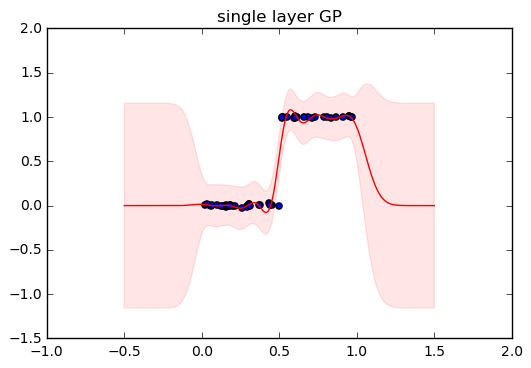

In [2]:
Ns = 300
Xs = np.linspace(-0.5, 1.5, Ns)[:, None]

N, M = 50, 25
X = np.random.uniform(0, 1, N)[:, None]
Z = np.random.uniform(0, 1, M)[:, None]
f_step = lambda x: 0. if x<0.5 else 1.
Y = np.reshape([f_step(x) for x in X], X.shape) + np.random.randn(*X.shape)*1e-2

def train_and_plot_gp(X, Y, kernel):
    m_gp = GPR(X, Y, kernel)
    m_gp.optimize()
    m, v = m_gp.predict_y(Xs)
    plt.plot(Xs, m, color='r')
    l = (m - 2*v**0.5).flatten()
    u = (m + 2*v**0.5).flatten()
    plt.fill_between(Xs.flatten(), l, u, color='r', alpha=0.1)
    plt.title('single layer GP')
    plt.scatter(X, Y)
    plt.show()
    
train_and_plot_gp(X, Y, RBF(1, lengthscales=0.2, variance=1))

We'll now use a 2 layer DGP

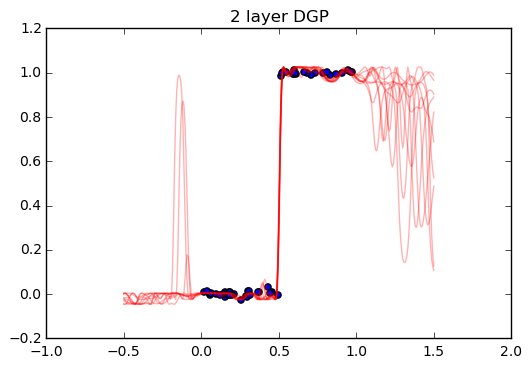

In [3]:
def make_DGP(L):
    kernels = []
    for l in range(L):
        k = RBF(1, lengthscales=0.2, variance=1) + White(1, variance=1e-5)
        kernels.append(k)
#     kernels.append(RBF(1, lengthscales=0.2, variance=1))

    m_dgp = DGP(X, Y, Z, kernels, Gaussian())
    
    # init the layers to near determinisic 
    for layer in m_dgp.layers[:-1]:
        layer.q_sqrt = layer.q_sqrt.value * 1e-5
    return m_dgp

m_dgp_2 = make_DGP(2)
m_dgp_2.optimize(tf.train.AdamOptimizer(0.01), maxiter=1000)#, callback=cb.cb)

for _ in range(10):
    samples = m_dgp_2.predict_f_full_cov(Xs)
    plt.plot(Xs, samples[0].reshape(Xs.shape), color='r', alpha=0.3)

plt.title('2 layer DGP')
plt.scatter(X, Y)
plt.show()

We can plot all the layers to see what's going on

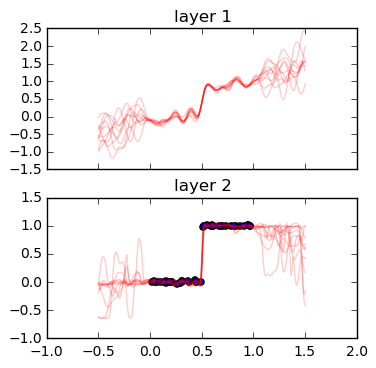

In [4]:
def plot_layers(model, X, Y):
    L = len(model.layers)
    f, axs = plt.subplots(L, 1, figsize=(4, 2*L), sharex=True)
    if L == 1:
        axs = [axs, ]

    for _ in range(10):
        samples = model.predict_all_layers_full_cov(Xs)
        for s, ax in zip(samples, axs):
            S, N, D  = s.shape
            for d in range(D):
                ax.plot(Xs.flatten(), s[:, :, d].T, color='r', alpha=0.2)

    axs[-1].scatter(X, Y)
    for l in range(L):
        axs[l].set_title('layer {}'.format(l+1))
    plt.show()

plot_layers(m_dgp_2, X, Y)


Here's the three layer version

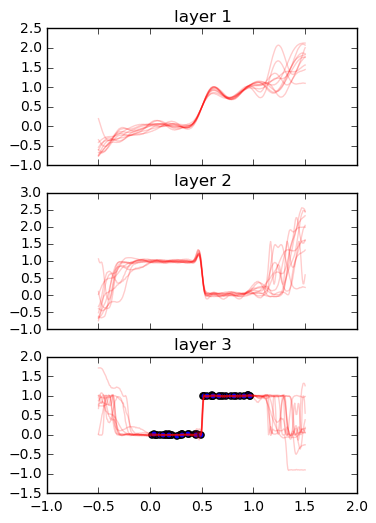

In [5]:
m_dgp_3 = make_DGP(3)
m_dgp_3.optimize(tf.train.AdamOptimizer(0.01), maxiter=1000)
plot_layers(m_dgp_3, X, Y)
